In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset

In [2]:
df = pd.read_csv("../DataSets/bitcoin_prices3.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df_chart = df.copy()
df

,timestamp,-1min,MA7,MA25,MA50,price
0,2023-04-12 17:05:00,NaN,NaN,NaN,NaN,29984.59
1,2023-04-12 17:06:00,29984.59,NaN,NaN,NaN,29987.64
2,2023-04-12 17:07:00,29987.64,NaN,NaN,NaN,30009.21
3,2023-04-12 17:08:00,30009.21,NaN,NaN,NaN,30028.80
4,2023-04-12 17:09:00,30028.80,NaN,NaN,NaN,30000.72
...,...,...,...,...,...,...
1996,2023-04-14 02:21:00,30787.58,30808.191429,30794.2388,30805.0860,30783.25
1997,2023-04-14 02:22:00,30783.25,30800.990000,30792.9664,30803.6900,30776.92
1998,2023-04-14 02:23:00,30776.92,30794.777143,30791.2240,30802.5780,30774.77
1999,2023-04-14 02:24:00,30774.77,30790.085714,30790.4420,30801.5878,30765.26


## Dataset Summary

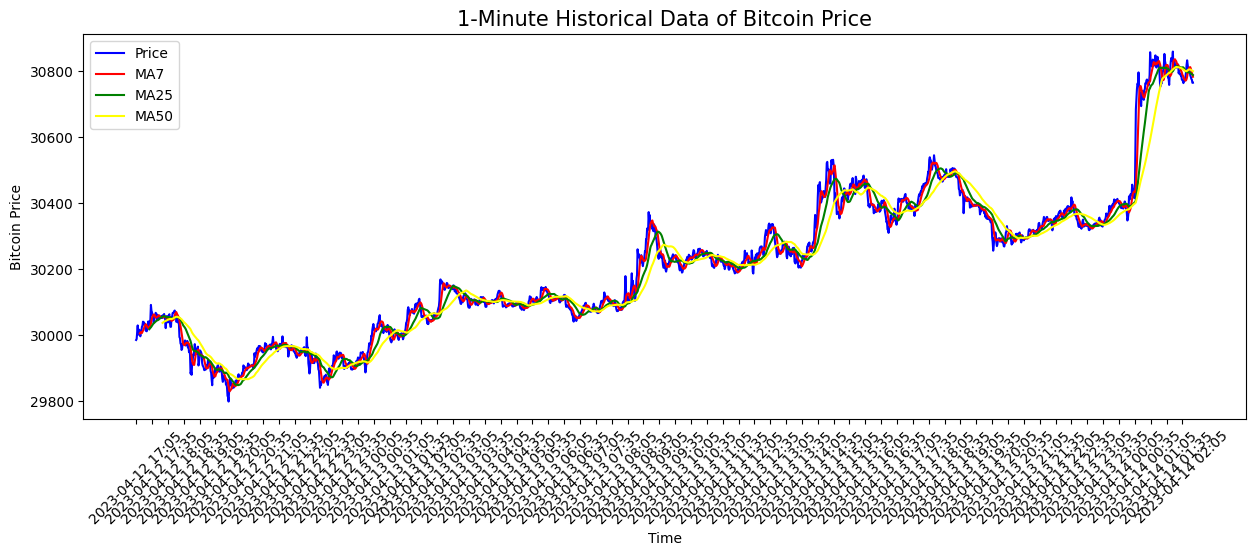

In [3]:
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'])
df_chart.set_index('timestamp', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['price'], color='blue', label='Price')
plt.plot(df_chart.index, df_chart['MA7'], color='red', label='MA7')
plt.plot(df_chart.index, df_chart['MA25'], color='green', label='MA25')
plt.plot(df_chart.index, df_chart['MA50'], color='yellow', label='MA50')
plt.title('1-Minute Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

tick_values = pd.date_range(start=df_chart.index[0], end=df_chart.index[-1], freq='30T')
tick_labels = [date.strftime('%Y-%m-%d %H:%M') for date in tick_values]
plt.xticks(tick_values, tick_labels, rotation=45)

plt.show()

In [4]:
#drop NAN rows
df = df.drop(df.index[:50])

feature_df = df.iloc[:,1:6]

In [5]:
feature_df

,-1min,MA7,MA25,MA50,price
50,30051.36,30053.120000,30055.5112,30036.3942,30059.15
51,30059.15,30053.554286,30056.2904,30037.8854,30053.22
52,30053.22,30053.992857,30056.9432,30039.1970,30058.14
53,30058.14,30055.067143,30057.3796,30040.1756,30063.53
54,30063.53,30056.302857,30056.2788,30040.8702,30050.95
...,...,...,...,...,...
1996,30787.58,30808.191429,30794.2388,30805.0860,30783.25
1997,30783.25,30800.990000,30792.9664,30803.6900,30776.92
1998,30776.92,30794.777143,30791.2240,30802.5780,30774.77
1999,30774.77,30790.085714,30790.4420,30801.5878,30765.26


In [6]:
#Feature Scaling
scalar = StandardScaler()
df_ft = scalar.fit_transform(feature_df.values)
df_ft = pd.DataFrame(columns=feature_df. columns,
                    data=df_ft,
                    index=feature_df.index)

In [7]:
df_ft

,-1min,MA7,MA25,MA50,price
50,-0.727433,-0.719379,-0.707547,-0.796046,-0.693499
51,-0.692840,-0.717438,-0.703994,-0.789037,-0.719796
52,-0.719174,-0.715477,-0.701016,-0.782873,-0.697978
53,-0.697325,-0.710675,-0.699026,-0.778273,-0.674075
54,-0.673389,-0.705152,-0.704046,-0.775008,-0.729863
...,...,...,...,...,...
1996,2.541976,2.655768,2.661678,2.817004,2.517613
1997,2.522747,2.623578,2.655874,2.810442,2.489542
1998,2.494637,2.595807,2.647928,2.805216,2.480007
1999,2.485089,2.574836,2.644361,2.800561,2.437834


In [8]:
def lstm_split(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps + 1):
        X.append (data[i:i + n_steps, : - 1])
        y.append(data[i + n_steps - 1, - 1])
    return np.array(X), np.array(y)

In [9]:
X1, y1 = lstm_split(df_ft.values, n_steps=50)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [12]:
print(X_train.shape, y_test.shape)

(1331, 50, 4) (571,)


## Sequential model

In [13]:
model = Sequential ()
model. add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])))
model. add (Dropout (0.2))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.2))
model. add(LSTM(units = 50, return_sequences= True))
model. add(Dropout (0.2))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Metal device set to: Apple M2


## Summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Train

In [15]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=1)

Epoch 1/50


2023-04-13 22:08:02.772238: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


42/42 [==============================] - 8s 70ms/step - loss: 0.2207 - accuracy: 0.0000e+00 - val_loss: 0.0408 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 1s 35ms/step - loss: 0.0459 - accuracy: 0.0000e+00 - val_loss: 0.0294 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 1s 34ms/step - loss: 0.0397 - accuracy: 0.0000e+00 - val_loss: 0.0248 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 1s 36ms/step - loss: 0.0332 - accuracy: 0.0000e+00 - val_loss: 0.0331 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 2s 36ms/step - loss: 0.0307 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 1s 35ms/step - loss: 0.0304 - accuracy: 0.0000e+00 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/50
42/42 [=====================

In [ ]:
# model.save('model_004.h5')
# loaded_model = keras.models.load_model('model_004.h5')

## Evaluate

In [19]:
y_pred = model.predict(X_test)

18/18 [==============================] - 0s 10ms/step


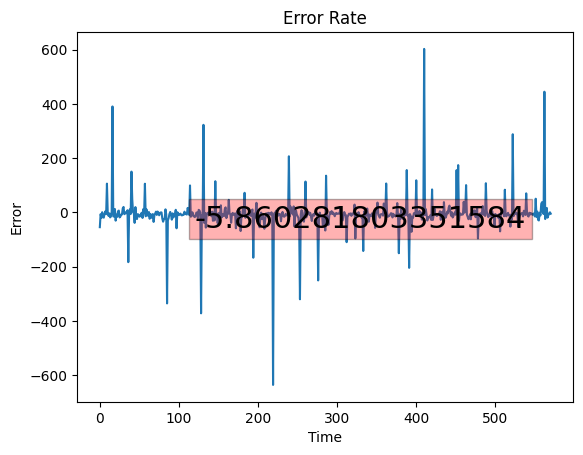

In [20]:
error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, average_error_rate, fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

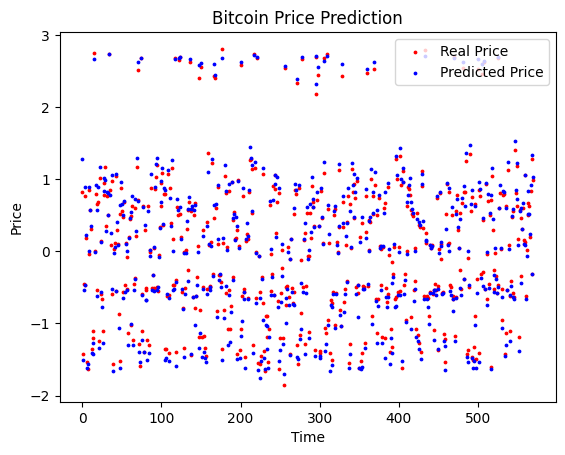

In [18]:
# Define y_test_index with row labels
y_test_index = range(len(y_test))

# Convert numpy arrays to pandas series
y_test_series = pd.Series(y_test.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred.reshape(-1,), index=y_test_index)

# Plot scatter plot
plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price', s=3)
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
